[1/6] Loading BCSC Dataset...
[2/6] Preprocessing: Handling Missing Values & Encoding...
[3/6] Training 4 Models (Recall-Prioritized)...

[4/6] Generating Performance Summary Table...
      Model  Precision  Recall  F1-Score  TP  FN
0  AdaBoost     0.0638  0.7885    0.1180  41  11
1       GBM     0.0632  0.7500    0.1166  39  13
2   XGBoost     0.0625  0.4423    0.1095  23  29
3  CatBoost     0.0565  0.4038    0.0991  21  31
[5/6] Generating Visualizations...
[6/6] Pipeline Execution Complete. Files saved to disk.


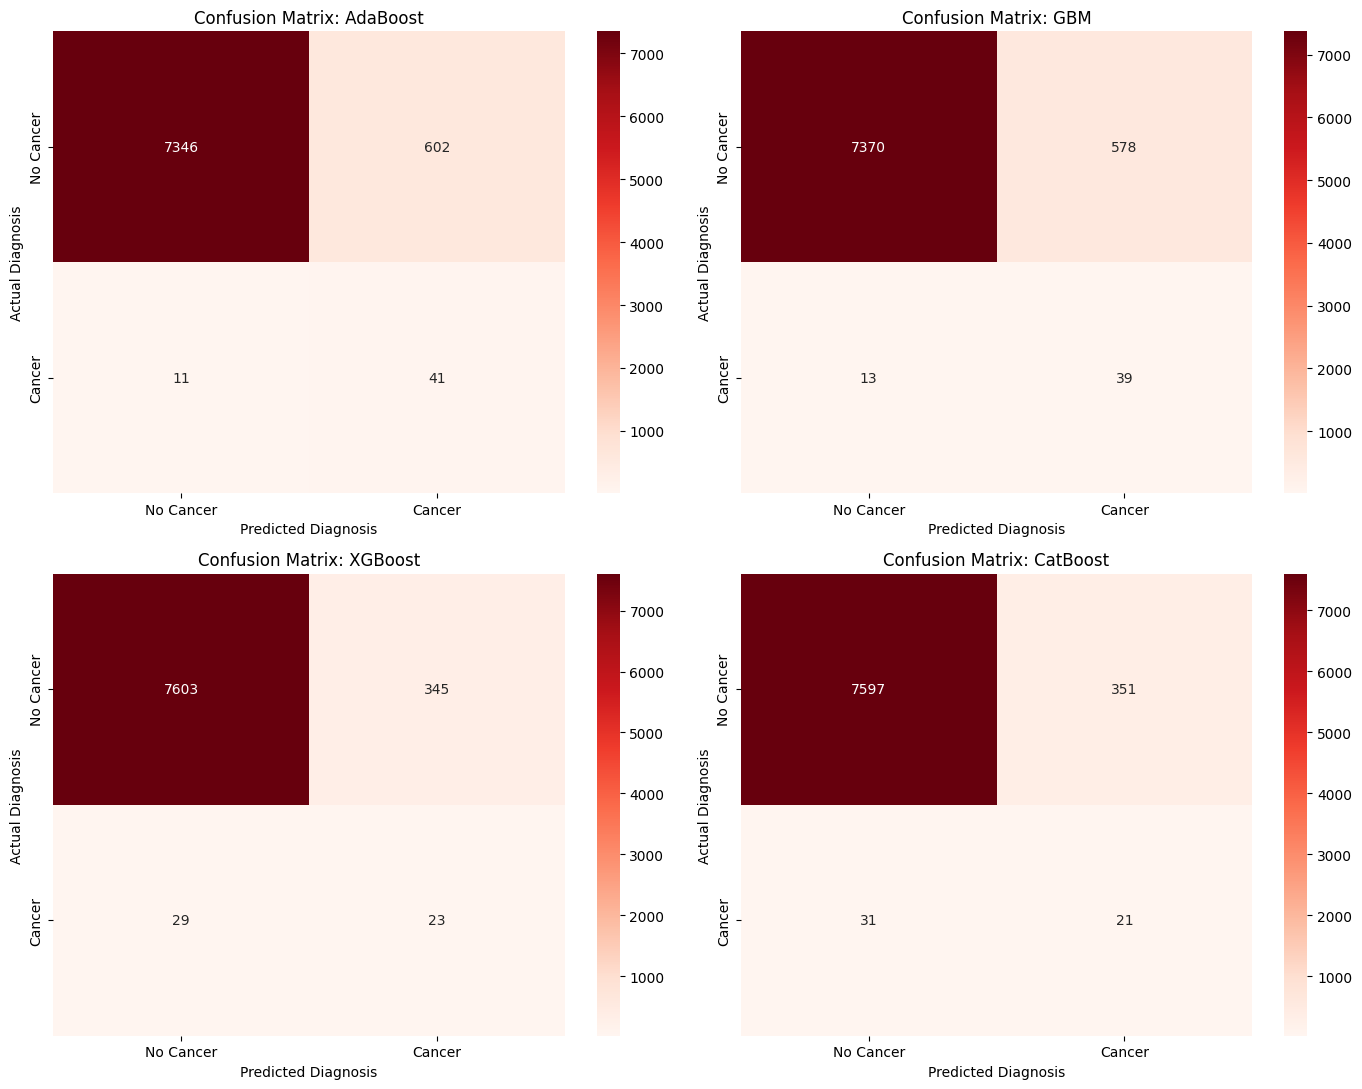

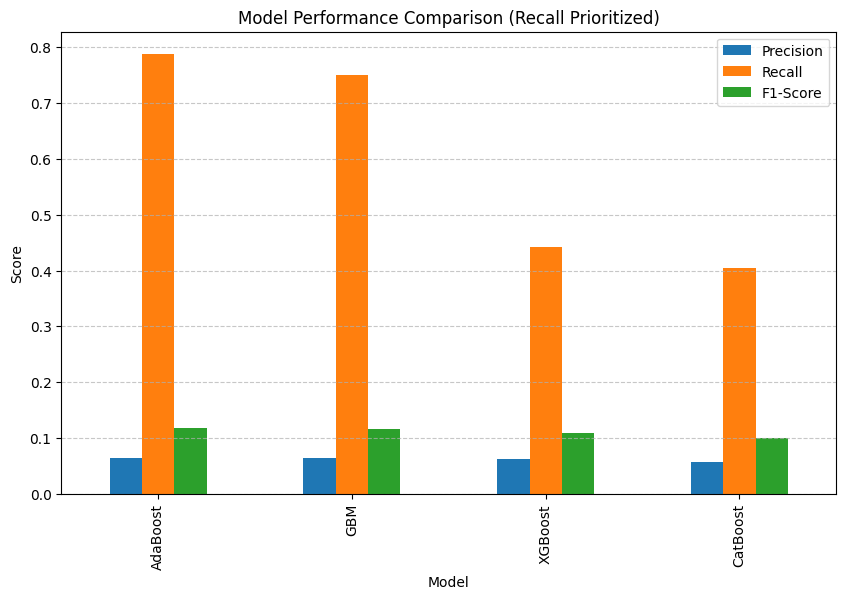

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Install libraries if running in a fresh Colab environment
try:
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
except ImportError:
    print("Installing missing libraries...")
    os.system('pip install xgboost catboost')
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier

def run_bcsc_screening_pipeline(csv_path='Dataset_BrestCancer.csv'):
    """
    Complete Evaluation Pipeline for Breast Cancer Early Screening.
    Implements: Preprocessing, Imbalance Handling, 4 Models, and Visualization.
    """
    try:
        print("[1/6] Loading BCSC Dataset...")
        df = pd.read_csv(csv_path)

        # 2. Preprocessing & Feature Engineering
        print("[2/6] Preprocessing: Handling Missing Values & Encoding...")

        # Define target and features
        # Target: cancer_c (diagnosis within 1 year)
        # Drop ptid (ID) and CaTypeO (leakage: info known only after diagnosis)
        target = 'cancer_c'
        X = df.drop(columns=['ptid', target, 'CaTypeO'])
        y = df[target]

        # Medical Mapping & Missing Value Handling (BCSC v3.1 Standards)
        # -99 in bmi_c is missing
        X['bmi_c'] = X['bmi_c'].replace(-99.0, np.nan)
        X['bmi_c'] = X['bmi_c'].fillna(X['bmi_c'].median())

        # 9 in categorical columns is 'Unknown' per BCSC documentation
        categorical_cols = ['assess_c', 'compfilm_c', 'density_c', 'famhx_c',
                            'hrt_c', 'prvmam_c', 'biophx_c', 'mammtype']

        for col in categorical_cols:
            X[col] = X[col].replace(9, np.nan)
            # Impute with most frequent (mode) to maintain dataset integrity
            X[col] = X[col].fillna(X[col].mode()[0])

        # One-Hot Encoding for categorical features (Required for AdaBoost/GBM/XGBoost)
        X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

        # 3. Stratified Split (80/20) - Maintains cancer prevalence ratio
        X_train, X_test, y_train, y_test = train_test_split(
            X_encoded, y, test_size=0.20, random_state=42, stratify=y
        )

        # Calculate Class Weights to prioritize Recall (Sensitivity)
        # Ratio is approx 153 negatives for every 1 positive
        neg_count = np.sum(y_train == 0)
        pos_count = np.sum(y_train == 1)
        imbalance_ratio = neg_count / pos_count

        # Compute sample weights for AdaBoost and GBM fit methods
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

        # 4. Model Initialization
        models = {
            "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
            "GBM": GradientBoostingClassifier(n_estimators=100, random_state=42),
            "XGBoost": XGBClassifier(scale_pos_weight=imbalance_ratio, eval_metric='logloss', random_state=42),
            "CatBoost": CatBoostClassifier(scale_pos_weight=imbalance_ratio, verbose=0, random_state=42)
        }

        results = []
        cms = {}

        # 5 & 6. Training, Prediction, and Metric Computation
        print("[3/6] Training 4 Models (Recall-Prioritized)...")
        for name, model in models.items():
            try:
                # Train with weights
                if name in ["AdaBoost", "GBM"]:
                    model.fit(X_train, y_train, sample_weight=sample_weights)
                else:
                    model.fit(X_train, y_train)

                # Predict
                y_pred = model.predict(X_test)

                # Compute Metrics
                cm = confusion_matrix(y_test, y_pred)
                prec = precision_score(y_test, y_pred, zero_division=0)
                rec = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                tn, fp, fn, tp = cm.ravel()

                results.append({
                    "Model": name,
                    "Precision": round(prec, 4),
                    "Recall": round(rec, 4),
                    "F1-Score": round(f1, 4),
                    "TP": tp, "TN": tn, "FP": fp, "FN": fn
                })
                cms[name] = cm
            except Exception as e:
                print(f"Error training {name}: {e}")

        # 7. Summary Table
        print("\n[4/6] Generating Performance Summary Table...")
        summary_df = pd.DataFrame(results)
        print(summary_df[["Model", "Precision", "Recall", "F1-Score", "TP", "FN"]])
        summary_df.to_csv('bcsc_model_performance.csv', index=False)

        # 8. Visualization - Confusion Matrix Heatmaps
        print("[5/6] Generating Visualizations...")
        fig, axes = plt.subplots(2, 2, figsize=(14, 11))
        axes = axes.flatten()

        for i, (name, cm) in enumerate(cms.items()):
            sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[i],
                        xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
            axes[i].set_title(f"Confusion Matrix: {name}")
            axes[i].set_xlabel("Predicted Diagnosis")
            axes[i].set_ylabel("Actual Diagnosis")

        plt.tight_layout()
        plt.savefig('confusion_matrices_v2.png')

        # 9. Performance Chart
        plt.figure(figsize=(10, 6))
        summary_df.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=plt.gca())
        plt.title('Model Performance Comparison (Recall Prioritized)')
        plt.ylabel('Score')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig('performance_comparison_v2.png')

        print("[6/6] Pipeline Execution Complete. Files saved to disk.")
        return summary_df

    except Exception as e:
        print(f"FATAL ERROR in Pipeline: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    run_bcsc_screening_pipeline()

--- Starting Pipeline with Threshold: 0.2 ---

--- Model Performance Summary (T=0.2) ---
      Model  Precision  Recall  F1-Score  TP    TN    FP  FN
0  AdaBoost     0.0065  1.0000    0.0129  52     0  7948   0
1       GBM     0.0356  0.8269    0.0683  43  6784  1164   9
2   XGBoost     0.0560  0.5577    0.1018  29  7459   489  23
3  CatBoost     0.0530  0.5577    0.0968  29  7430   518  23
Performance comparison chart saved as 'performance_comparison_threshold_02.png'.


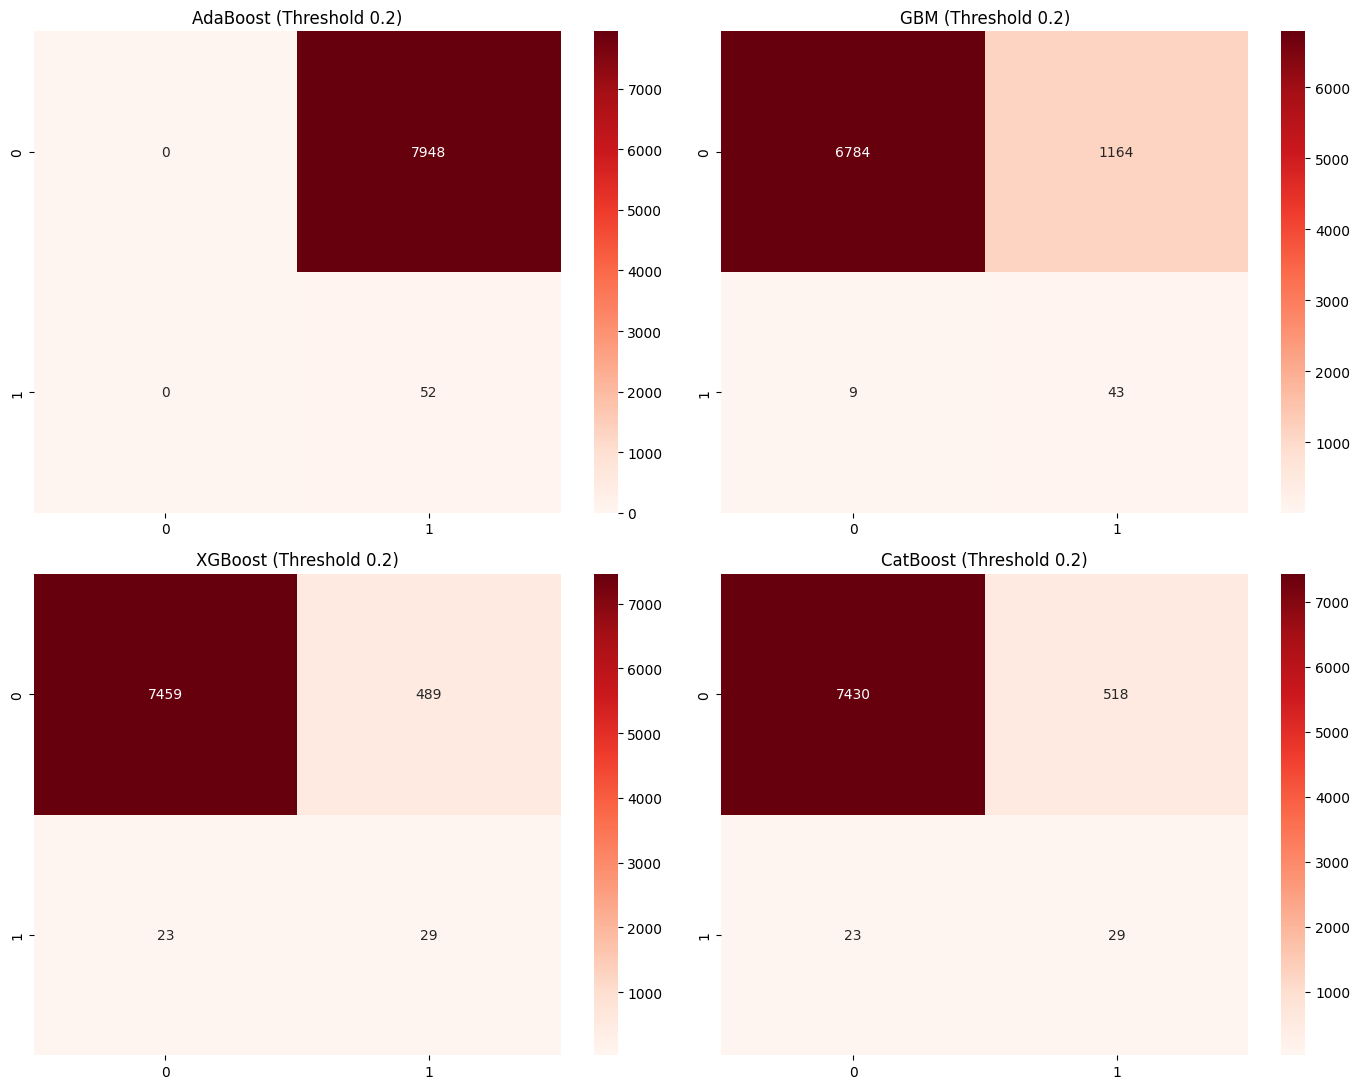

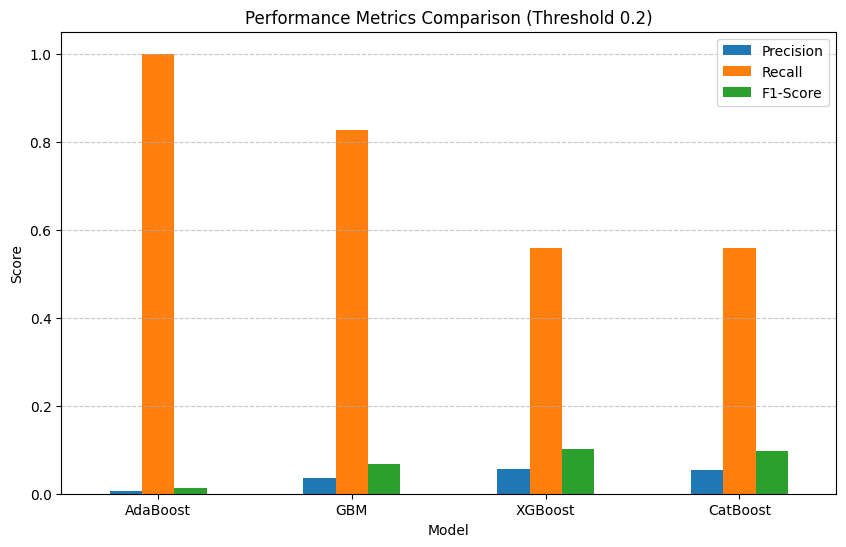

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Optional: Handle imports for XGBoost and CatBoost
try:
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
except ImportError:
    import os
    os.system('pip install xgboost catboost')
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier

def run_recall_maximized_pipeline(file_path='Dataset_BrestCancer.csv', threshold=0.2):
    print(f"--- Starting Pipeline with Threshold: {threshold} ---")

    # 1. Load & Preprocess
    df = pd.read_csv(file_path)
    X = df.drop(columns=['ptid', 'cancer_c', 'CaTypeO'])
    y = df['cancer_c']

    X['bmi_c'] = X['bmi_c'].replace(-99.0, np.nan).fillna(X['bmi_c'].median())
    categorical_cols = ['assess_c', 'compfilm_c', 'density_c', 'famhx_c', 'hrt_c', 'prvmam_c', 'biophx_c', 'mammtype']
    for col in categorical_cols:
        X[col] = X[col].replace(9, np.nan).fillna(X[col].mode()[0])

    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

    # Calculate Weights
    ratio = float(np.sum(y_train == 0) / np.sum(y_train == 1))
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    models = {
        "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
        "GBM": GradientBoostingClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(scale_pos_weight=ratio, eval_metric='logloss', random_state=42),
        "CatBoost": CatBoostClassifier(scale_pos_weight=ratio, verbose=0, random_state=42)
    }

    results = []
    fig, axes = plt.subplots(2, 2, figsize=(14, 11))
    axes = axes.flatten()

    for i, (name, model) in enumerate(models.items()):
        # Train
        if name in ["AdaBoost", "GBM"]:
            model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            model.fit(X_train, y_train)

        # Predict Probabilities and Apply Custom Threshold
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= threshold).astype(int)

        cm = confusion_matrix(y_test, y_pred)
        results.append({
            "Model": name,
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1-Score": f1_score(y_test, y_pred, zero_division=0),
            "TP": cm[1,1], "TN": cm[0,0], "FP": cm[0,1], "FN": cm[1,0]
        })

        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[i])
        axes[i].set_title(f"{name} (Threshold {threshold})")

    plt.tight_layout()
    plt.savefig('confusion_matrices_threshold_02.png')

    summary_df = pd.DataFrame(results).round(4)
    print("\n--- Model Performance Summary (T=0.2) ---")
    print(summary_df)
    summary_df.to_csv('model_summary_threshold_02.csv', index=False)

    # --- ADDED: Performance Comparison Plot ---
    plt.figure(figsize=(10, 6))
    summary_df.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=plt.gca())
    plt.title(f'Performance Metrics Comparison (Threshold {threshold})')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('performance_comparison_threshold_02.png')
    print(f"Performance comparison chart saved as 'performance_comparison_threshold_02.png'.")

if __name__ == "__main__":
    run_recall_maximized_pipeline()